In [1]:
import pandas as pd
import numpy as np
import time
from PIL import Image

In [11]:
df_pla = pd.read_csv("TFT_Platinum_MatchData.csv") # TFT_Platinum_MatchData.csv
df_dia = pd.read_csv("TFT_Diamond_MatchData.csv") # TFT_Diamond_MatchData.csv
df_ma = pd.read_csv("TFT_Master_MatchData.csv") # TFT_Master_MatchData.csv
df_gma = pd.read_csv("TFT_GrandMaster_MatchData.csv") # TFT_GrandMaster_MatchData.csv
df_chl = pd.read_csv("TFT_Challenger_MatchData.csv") #TFT_Challenger_MatchData.csv
df_cham = pd.read_csv("TFT_Champion_CurrentVersion.csv") #TFT_Champion_CurrentVersion.csv
df_item = pd.read_csv("TFT_Item_CurrentVersion.csv") #TFT_Item_CurrentVersion.csv

In [9]:
# 분석할 데이터의 행과 열 개수
"테이블 열과 행 갯수", "platinum", df_pla.shape,"dia", df_dia.shape, "master", df_ma.shape, "grandmaster", df_gma.shape, "challenger", df_chl.shape, "champion", df_cham.shape, "item", df_item.shape

('테이블 열과 행 갯수',
 'platinum',
 (80000, 8),
 'dia',
 (80000, 8),
 'master',
 (79999, 8),
 'grandmaster',
 (80000, 8),
 'challenger',
 (79999, 8),
 'champion',
 (52, 12),
 'item',
 (54, 2))

In [21]:
# 컬럼 타입 확인 / Non-Null Count와 행 수가 같으므로 결측치 없음
df_pla.info(),df_dia.info(), df_ma.info(), df_gma.info(), df_chl.info(), df_cham.info(), df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          80000 non-null  object 
 1   gameDuration    80000 non-null  float64
 2   level           80000 non-null  int64  
 3   lastRound       80000 non-null  int64  
 4   Ranked          80000 non-null  int64  
 5   ingameDuration  80000 non-null  float64
 6   combination     80000 non-null  object 
 7   champion        80000 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 4.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          80000 non-null  object 
 1   gameDuration    80000 non-null  float64
 2   level           80000 non-null  int64  
 3   lastRound       80000 non-null  int64  
 4

(None, None, None, None, None, None, None)

In [24]:
# 티어 구분 컬럼을 추가해준 뒤, 모든 티어 테이블 결합 (매치 데이터로 한번에 데이터를 보기 위해)

df_pla['tier'] = 'Platinum'
df_dia['tier'] = 'Diamond'
df_ma['tier'] = 'Master'
df_gma['tier'] = 'Grandmaster'
df_chl['tier'] = 'Challenger'

In [26]:
#데이터 수직 결합(axis=0) concat / ignore_index=True : 인덱스 재배열
df_alltier = pd.concat([df_pla, df_dia, df_ma, df_gma, df_chl], axis=0, ignore_index=True, join='inner')

In [79]:
#기술통계(min/median/mean/max, 결측치 수)를 제시하여 EDA를 수행
df_alltier.describe()

# "이상치 0. 중복 / 누락 게임 아이디 거르기 (게임 한 판 당 8명 - count가 8개가 아닌 경우 제거)
# "이상치 1. TFT 순위는 1위부터 8위 사이, 랭크 컬럼의 최솟값 0 제거 필요"
# "이상치 2. 정상 게임시간 5분~60분을 기준으로 잡음, 최댓값은 46분이므로 5분 미만 게임 제거 필요"
# "이상치 3. 마지막 라운드가 0인 경우 제거, 정상 게임시간 필터링 후 확인"


,gameDuration,level,lastRound,Ranked,ingameDuration
count,399998.000000,399998.000000,399998.000000,399998.000000,399998.000000
mean,2158.849411,7.854157,33.526310,4.499067,1878.570623
std,143.213755,0.783634,4.806737,2.292066,269.221503
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2066.230042,7.000000,30.000000,2.000000,1705.843018
50%,2153.773193,8.000000,34.000000,4.000000,1900.351257
75%,2247.653870,8.000000,37.000000,6.000000,2066.977966
max,2775.935547,9.000000,51.000000,8.000000,2767.582275


In [88]:
# (이상치 0) 중복 아이디 체크 - 게임 한 판 당 8명이므로 같은 게임 아이디가 8개 있어야 함.

#우선 게임 아이디가 중복 8개가 아닌 경우의 수를 셈

df_0 = df_alltier.copy()

# 각 gameId별로 행의 개수를 계산
game_counts = df_0['gameId'].value_counts()
abnormal_games = game_counts[game_counts != 8]

print("정상 게임 수:", game_counts[game_counts == 8].count())
print("비정상 게임 수:", abnormal_games.count())

정상 게임 수: 49960
비정상 게임 수: 21


In [95]:
#이상치 1 게임 아이디 중복 및 누락 체크

# .size() - gameId 그룹에 속하는 행(기록)의 개수 계산 후 Pandas Series로 반환
# 위 Series의 "인덱스"는 고유한 "gameId"가 되고, "값"은 해당 gameId의 "개수"가 됨
#  .reset_index - 인덱스(gameId)와 값(개수)을 일반 컬럼으로 다루기 쉽도록 데이터프레임(DataFrame)으로 변환

df_grouped = df_0.groupby('gameId').size().reset_index(name='counts')
ab_games = df_grouped[df_grouped['counts'] != 8]
print('비정상 게임 Id', ab_games)

abnormal_games_list = ab_games['gameId'].tolist()
print('비정상 게임 Id')
print(abnormal_games_list)

비정상 게임 Id               gameId  counts
2432   KR_4263820118      16
10243  KR_4313697214      16
12053  KR_4318806255       7
12525  KR_4320079059      16
20067  KR_4335870255       7
25323  KR_4344513862      16
27702  KR_4347884427      16
34207  KR_4357966612      16
34976  KR_4358922415      16
37414  KR_4361594426      16
37573  KR_4361773461      16
38720  KR_4362846604      16
39928  KR_4364453473      16
40896  KR_4365284161      16
43914  KR_4378896137      16
44448  KR_4381231118      16
45665  KR_4387025966      16
45726  KR_4387247645      16
45850  KR_4388134708      16
47563  KR_4393787119      16
49148  KR_4398618214      16
비정상 게임 Id
['KR_4263820118', 'KR_4313697214', 'KR_4318806255', 'KR_4320079059', 'KR_4335870255', 'KR_4344513862', 'KR_4347884427', 'KR_4357966612', 'KR_4358922415', 'KR_4361594426', 'KR_4361773461', 'KR_4362846604', 'KR_4364453473', 'KR_4365284161', 'KR_4378896137', 'KR_4381231118', 'KR_4387025966', 'KR_4387247645', 'KR_4388134708', 'KR_4393787119', '

In [96]:
# 1. 이상치 게임 ID 목록 준비
games_to_remove = df_grouped[df_grouped['counts'] == 7]['gameId'].tolist()
games_to_deduplicate = df_grouped[df_grouped['counts'] == 16]['gameId'].tolist()


# 2. 메인 데이터프레임에서 제거 대상(7개) 및 중복 대상(16개) 분리

# 2-1. 정상 데이터 및 유니크 처리할 16개 게임 데이터만 남김 (7개짜리 게임 ID 제거)
df_semi_cleaned = df_0[~df_0['gameId'].isin(games_to_remove)].copy()
# 2-2. 중복을 제거할 16개 게임 데이터 추출
data_16_raw = df_semi_cleaned[df_semi_cleaned['gameId'].isin(games_to_deduplicate)].copy()
# 2-3. 정상적인 8개 행 게임 데이터만 추출
data_clean_8 = df_semi_cleaned[~df_semi_cleaned['gameId'].isin(games_to_deduplicate)].copy()


# 3. 16개 게임 데이터 유니크 처리
# 'gameId'와 'Ranked'가 모두 같은 경우를 중복으로 간주하고 제거 (즉, 16개 -> 8개로 만듦)
# subset=['gameId', 'Ranked'] 역할: 중복을 판단할 기준(컬럼)을 지정
data_16_unique = data_16_raw.drop_duplicates(subset=['gameId', 'Ranked'], keep='first').copy()


# 4. 최종 데이터 합치기
# 정상 데이터(8개)와 중복 제거된 데이터(16개 -> 8개)를 합침
df_cleaned_0 = pd.concat([data_clean_8, data_16_unique], ignore_index=True)


# 5. 결과 확인
removed_rows = len(df_0) - len(df_cleaned_0)
print(f"제거 및 유니크 처리 후 최종 행 수: {df_cleaned_0.shape[0]} 행")
print(f"총 제거된 행 수: {removed_rows} 행")

제거 및 유니크 처리 후 최종 행 수: 399832 행
총 제거된 행 수: 166 행


In [94]:
### 정리 (19*16)-(19*8)=152 / (2*7)=14 / 합쳐서 166 행 제거 확인

In [98]:
# (이상치 1) 0위 제거

df = df_cleaned_0.copy()

# 1. 제거 전 행 개수 확인
zero_rank_count = len(df[df['Ranked'] == 0])
print(f"제거 이전에 순위가 0인 행의 개수: {zero_rank_count}개")

# 2. 'Ranked' 컬럼 값이 0이 아닌 (정상 범위: 1~8) 행들만 선택
df_cleaned = df[df['Ranked'] != 0].copy()

# 3. 제거 후 행 개수 확인
after_rank_clean = len(df_cleaned)

# 4. 제거된 행 수 출력
removed_rows = len(df) - after_rank_clean
print(f"순위(Ranked)가 0인 데이터: {removed_rows}개 행 제거됨.")

# 이후 df_cleaned 데이터프레임 사용

제거 이전에 순위가 0인 행의 개수: 92개
순위(Ranked)가 0인 데이터: 92개 행 제거됨.


In [99]:
# (이상치2) 게임시간 5분 미만 거르기

MIN_DURATION_SECONDS = 300  # 5분 (300초)을 최소 기준으로 설정

# 1. 제거 전 행 개수 확인
before_clean_time = len(df_cleaned)

# 2. 게임 시간(gameDuration) 또는 개인 시간(ingameDuration)이 300초 미만인 행들을 제외
df_cleaned_2 = df_cleaned[
    (df_cleaned['gameDuration'] >= MIN_DURATION_SECONDS) & 
    (df_cleaned['ingameDuration'] >= MIN_DURATION_SECONDS)
].copy()

# 3. 제거 후 행 개수 확인
after_clean_time = len(df_cleaned_2)

# 4. 제거된 행 수 출력
removed_rows_duration = before_clean_time - after_clean_time
print(f"최소 시간 {MIN_DURATION_SECONDS}초 미만인 비정상 게임 기록: {removed_rows_duration}개 행 제거됨.")

최소 시간 300초 미만인 비정상 게임 기록: 61개 행 제거됨.


In [100]:
df_cleaned_2.describe()

# 이상치 3의 문제(마지막 라운드 최솟값 0)가 해결됨

,gameDuration,level,lastRound,Ranked,ingameDuration
count,399679.000000,399679.000000,399679.000000,399679.000000,399679.000000
mean,2159.592256,7.856162,33.537646,4.500056,1879.221179
std,138.037331,0.776711,4.773555,2.291293,267.246519
min,452.641998,4.000000,10.000000,1.000000,450.532745
25%,2066.341797,7.000000,30.000000,3.000000,1706.109497
50%,2153.835205,8.000000,34.000000,5.000000,1900.488403
75%,2247.677856,8.000000,37.000000,7.000000,2067.051758
max,2775.935547,9.000000,51.000000,8.000000,2767.582275


In [101]:
# 제시된 IQR로 이상치 시각화 그래프 확인

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm # 폰트 관리 모듈

In [102]:
# 폰트 없다고 깨질 때
# 시스템에 설치된 폰트 경로 찾기
# 사용 가능한 한글 폰트 이름 사용
font_name = fm.FontProperties(fname="C:/Windows/Fonts/a타이틀고딕2.ttf").get_name() 

# Matplotlib의 폰트 설정
plt.rc('font', family=font_name)

# 마이너스 부호 깨짐 방지 설정
# (시각화 시 축에 마이너스 기호가 나타날 경우 깨지는 현상 방지)
plt.rcParams['axes.unicode_minus'] = False 

print(f"Matplotlib 폰트 설정 완료: {font_name}")

Matplotlib 폰트 설정 완료: KoreanTITGD2R


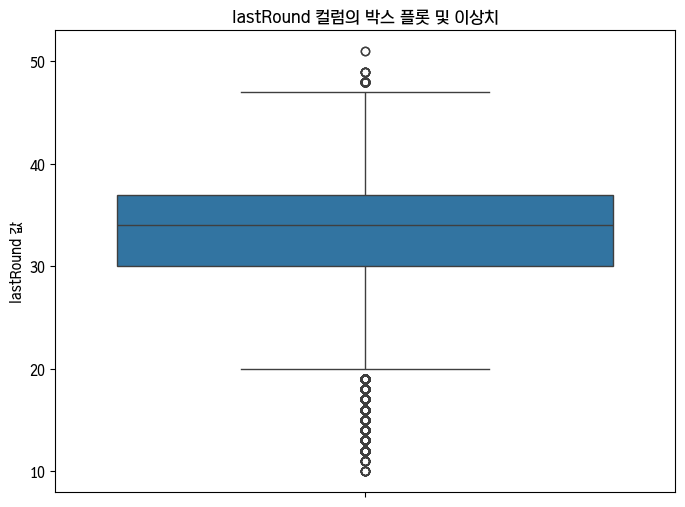

In [103]:
# (이상치 3) 마지막 라운드의 이상치 범위 확대 

# 시각화할 컬럼 이름 설정
COLUMN_NAME = 'lastRound'

plt.figure(figsize=(8, 6))

# seaborn의 boxplot 함수를 사용하여 시각화
# 박스 플롯은 Q1, 중앙값, Q3를 상자로 보여주며, 1.5*IQR을 벗어나는 데이터는 점(이상치)으로 표시
sns.boxplot(y=df_cleaned_2[COLUMN_NAME])

plt.title(f'{COLUMN_NAME} 컬럼의 박스 플롯 및 이상치')
plt.ylabel(f'{COLUMN_NAME} 값')
plt.show()

# "상한선의 동그라미들은 수가 적고, 있을 수 있는 장기전 게임이라고 판단하고 일단 넘어감"
# "하한선의 동그라미들은 상한선보다 훨씬 많아 구분이 필요"
# "11라운드 이하를 서버 문제, 게임 시작 직후 바로 항복 등 명백한 비정상 종료 기록일 가능성이 매우 높다고 판단"
# "초반 운영 전략 실패(리롤 실패, 오픈포트리스 등)로 빠른 gg를 칠 수 있는 경우를 가정해 10➡️12라운드부터 살림 판단"

## "여기서 초반 운영 전략 실패하는 경우의 데이터(골드,레벨,저코스트기물 등)를 모아 그래프를 보여줘도 괜찮다는 생각을 함"

In [64]:
### "게임 이해를 위한 설명" ###

# 리롤 전략 - 저렴한 챔피언들을 3성으로 빠르게 완성하여 초중반에 압도적인 강한 것이 목표
# 플레이어는 3-2 라운드나 4-1 라운드와 같은 특정 시점에 모아둔 골드를 모두 소진하며 승부수
# 실패일 때 
# 1. 리롤 타이밍에 수십 번의 상점 새로고침에도 불구하고, 핵심 유닛을 3성으로 완성하지 못하는 경우를 의미
# 2. 3성을 완성하지 못하면 보드에 2성 유닛들만 남아있게 됨
# 3. 이는 정상적인 덱(레벨을 올려 고코스트 챔피언을 쓰는 덱)보다 전투력이 훨씬 떨어짐

# 오픈포트리스 전략
# 초반 연패(Open Fort): 초반에 일부러 패배하여 골드 이자를 극대화
# 체력 관리 실패 시 20라운드 이전에 너무 낮은 순위로 빠르게 탈락할 수 있다.


In [104]:
# (이상치3) 범위 확대 - 11라운드 이하를 비정상 경기로 판단
### "12라운드부터 삭제된 행이 100단위로 늘어나서 11까지만 비정상으로 판단함"

df_cleaned_3 = df_cleaned_2.copy()

# 1. 제거 전 행 개수 확인
before_lastround_clean = len(df_cleaned_3)

# 2. 'lastRound' 컬럼 값이 10 이상인 (> 11) 행들만 선택
#    11 이하의 값(1~11 라운드)을 가진 행은 제거됨
df_cleaned_3 = df_cleaned_3[df_cleaned_3['lastRound'] > 11].copy()

# 3. 제거 후 행 개수 및 결과 출력
after_lastround_clean = len(df_cleaned_3)
removed_lastround_rows = before_lastround_clean - after_lastround_clean

print(f"lastRound가 11 이하인 비정상/초기 탈락 기록: {removed_lastround_rows}개 행 제거됨.")


lastRound가 11 이하인 비정상/초기 탈락 기록: 28개 행 제거됨.


In [107]:
'''
결측치 0
이상치 347
[0.중복 152개, 미달 14개 총 166개 행 제거
1. 순위가 0위인 경우 92개 행 제거
2. 5분 미만인 게임 61개 행 제거
3. 마지막 라운드 11이하인 게임 28개 행 제거]
'''
# 제거 전 행 개수 확인
before_all_clean = len(df_alltier)

# 제거 후 행 개수 및 결과 출력
after_all_clean = before_all_clean - len(df_cleaned_3)

print(f"이상치 {after_all_clean}개 행 제거됨.")

이상치 347개 행 제거됨.


In [108]:
# df_cleaned_3: 최종적으로 정리된 데이터프레임
# 'cleanmatch_c.csv': 저장할 파일 이름

df_cleaned_3.to_csv(
    'cleanmatch_c.csv', 
    index=False, 
    encoding='utf-8-sig'
)

print("클리닝이 완료된 데이터가 'cleanmatch' 파일로 성공적으로 저장되었습니다.")

클리닝이 완료된 데이터가 'cleanmatch' 파일로 성공적으로 저장되었습니다.
